In [23]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import iv as Iv #Modified Bessel function of the first kind of real order.
import scipy.special as sc

from scipy.stats import rice

from scipy.stats.mstats import gmean
from multiprocessing import cpu_count

from pathos.pools import ProcessPool as Pool

import copy 

import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

%config Completer.use_jedi = False
%matplotlib inline

# import data

In [2]:
fres = np.array([2.3, 5, 23, 28, 33]); nu0 = gmean(fres); nside = 32

In [3]:
total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_%s_uK_RJ_000.npy'%nside)#/1000 ## from uK to mK
total_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_sigma_P_%s_uK_RJ.npy'%nside)#/1000 ## from uK to mK
P_nu0 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_nu0_s0_%s_uK_RJ.npy'%nside)#/1000

mask_both = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_both_%s.npy'%nside)
mask_index = np.load('/global/cscratch1/sd/jianyao/CBASS/masked_index.npy')

In [16]:
total_sigma[:,0]

array([73.39660293, 40.90663706,  3.90321875,  3.88658586,  2.44109516])

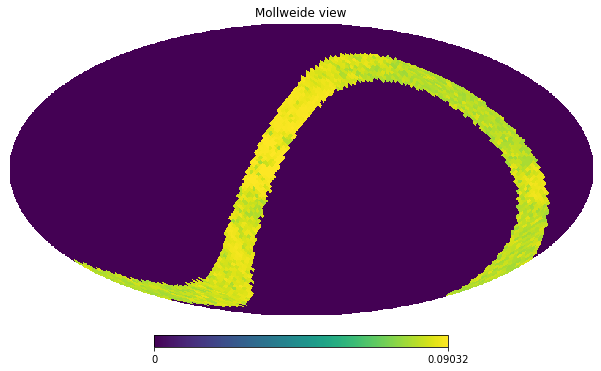

In [6]:
hp.mollview(total_P[4]*mask_both, norm = 'hist')

In [8]:
max(total_P[1][mask_index])

25.65558731684561

# Zero order Modified Bessel Function of the First Kind

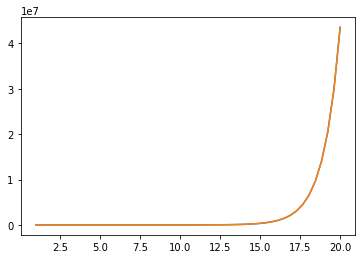

In [25]:
xs = np.linspace(1,20, 50)
plt.plot(xs, Iv(0, xs))
plt.plot(xs, sc.i0(xs))

# likelihood

In [240]:
def Pro(fre, index, A0, beta):
    
    p = total_P[fre][index]; 
    sigma = total_sigma[fre][index] #???????????????
    nu1 = fres[fre]
    
    exp = -(p**2 + (A0*(nu1/nu0)**(beta))**2)/2/sigma**2
    
    x = p*A0*(nu1/nu0)**(beta)/sigma**2
    pro = p/sigma**2*np.exp(exp)*Iv(0, x)
    
    return pro


# using scipy special function **rice** to improving the numerical stability of I0
# https://github.com/scipy/scipy/blob/v1.7.0/scipy/stats/_continuous_distns.py#L7220
def Pro_test(fre, index, A0, beta):
    nu1 = fres[fre]
    P = total_P[fre][index]; 
    
    P0 = A0*(nu1/nu0)**(beta)
    sigma = total_sigma[fre][index]
    
    pro = rice.pdf(P, P0/sigma, scale=sigma)
    return pro
    
    
index = 0; nu0 = gmean(fres)

Pro = Pro_test ## use modified pdf instead
def loglikeli(cube):
    A0 = cube[0];
    beta = cube[1];   
    pro0 = Pro(0, index, A0, beta)
    pro1 = Pro(1, index, A0, beta)
    pro2 = Pro(2, index, A0, beta)
    pro3 = Pro(3, index, A0, beta)
    pro4 = Pro(4, index, A0, beta)
    
#     print(pro0, pro1, pro2, pro3, pro4)
    L = (pro0*pro1*pro2*pro3*pro4)
#     print(L)
    if L == 0:
        logL = -1e30
        return logL
    else:
        return np.log(L)

In [241]:
P_nu0[index]

17.77469

In [ ]:
12*64**2

In [246]:
npara = 2; 

def prior(cube):
    A0 = cube[0]*1000 # 0-100
    beta = cube[1]*2 - 4
    
    return [A0, beta]


# Run MC and plot

In [265]:
sampler = dynesty.NestedSampler(loglikeli, prior, npara, nlive=1000, bootstrap = 0)
sampler.run_nested(dlogz = 0.1)
results = sampler.results

iter: 6268 | +1000 | bound: 8 | nc: 1 | ncall: 45196 | eff(%): 16.081 | loglstar:   -inf < -19.346 <    inf | logz: -23.263 +/-    nan | dlogz:  0.000 >  0.100                                       

In [155]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
resamples = dyfunc.resample_equal(samples, weights)

In [157]:
resamples.shape

(8702, 2)

In [158]:
np.mean(resamples[:,0])

64.3697831823126

In [159]:
np.mean(resamples[:,1])

-3.032877002730301

Text(0.5, 0.98, 'Pixel 0')

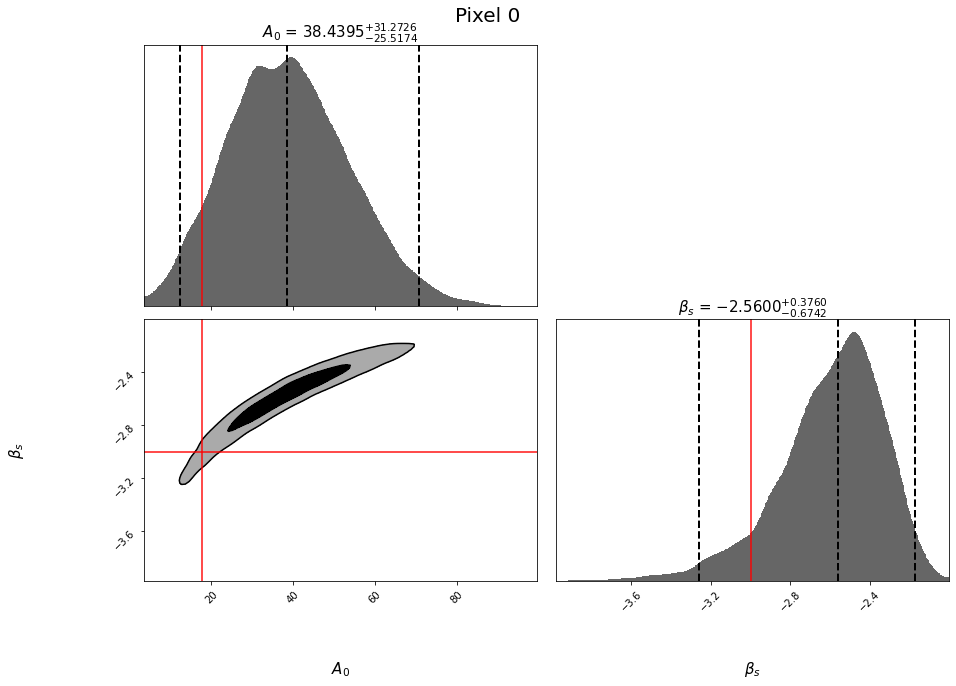

In [266]:
truth = np.array([P_nu0[index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];


labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15}, show_titles=True,
                 labels = labels,label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel 0", fontsize="20")

In [ ]:
truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

In [ ]:
12

# Results analysis

## S/N

In [32]:
total_P.shape

(5, 12288)

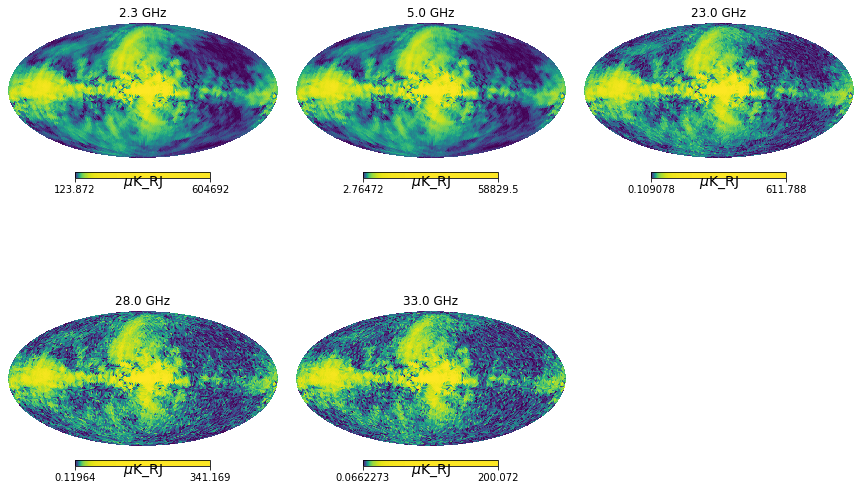

In [31]:
plt.figure(figsize = (12, 8))
hp.mollview(total_P[0], norm = 'hist', unit = '$\mu$K_RJ', sub = 231, title = '%s GHz' % fres[0]) 
hp.mollview(total_P[1], norm = 'hist', unit = '$\mu$K_RJ', sub = 232, title = '%s GHz' % fres[1]) 
hp.mollview(total_P[2], norm = 'hist', unit = '$\mu$K_RJ', sub = 233, title = '%s GHz' % fres[2]) 
hp.mollview(total_P[3], norm = 'hist', unit = '$\mu$K_RJ', sub = 234, title = '%s GHz' % fres[3]) 
hp.mollview(total_P[4], norm = 'hist', unit = '$\mu$K_RJ', sub = 235, title = '%s GHz' % fres[4]) 

In [36]:
total_sigma.shape

(5, 12288)

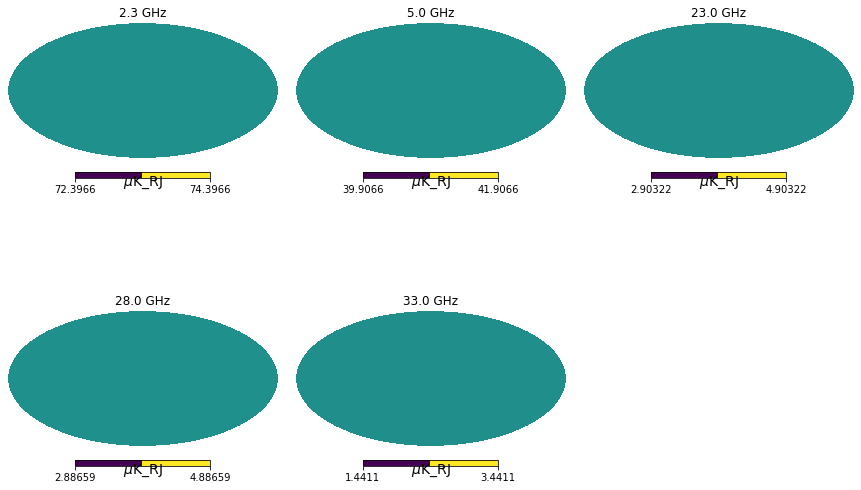

In [38]:
plt.figure(figsize = (12, 8))
hp.mollview(total_sigma[0], norm = 'hist', unit = '$\mu$K_RJ', sub = 231, title = '%s GHz' % fres[0]) 
hp.mollview(total_sigma[1], norm = 'hist', unit = '$\mu$K_RJ', sub = 232, title = '%s GHz' % fres[1]) 
hp.mollview(total_sigma[2], norm = 'hist', unit = '$\mu$K_RJ', sub = 233, title = '%s GHz' % fres[2]) 
hp.mollview(total_sigma[3], norm = 'hist', unit = '$\mu$K_RJ', sub = 234, title = '%s GHz' % fres[3]) 
hp.mollview(total_sigma[4], norm = 'hist', unit = '$\mu$K_RJ', sub = 235, title = '%s GHz' % fres[4]) 

In [230]:
S_to_N = (total_P/total_sigma)
S_to_N = hp.ma(S_to_N)
S_to_N.mask = np.logical_not(mask_both)

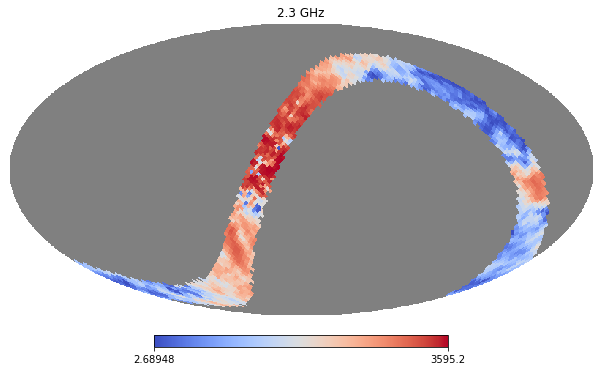

In [231]:
hp.mollview(S_to_N[0], norm = 'hist', title = '%s GHz' % fres[0], cmap = 'coolwarm') 

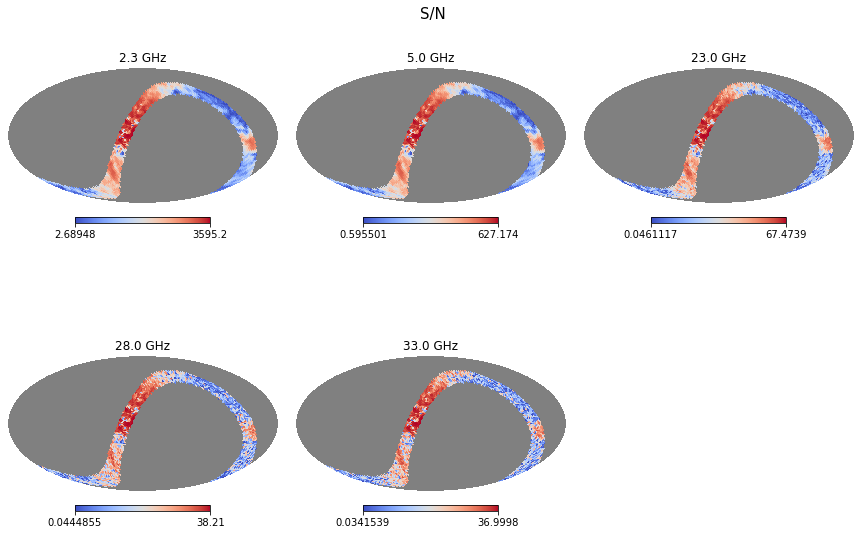

In [222]:
plt.figure(figsize = (12, 8))
plt.title('S/N', fontsize = 15)
plt.axis('off')
hp.mollview(S_to_N[0], norm = 'hist', sub = 231, title = '%s GHz' % fres[0], cmap = 'coolwarm') 
hp.mollview(S_to_N[1], norm = 'hist', sub = 232, title = '%s GHz' % fres[1], cmap = 'coolwarm') 
hp.mollview(S_to_N[2], norm = 'hist', sub = 233, title = '%s GHz' % fres[2], cmap = 'coolwarm') 
hp.mollview(S_to_N[3], norm = 'hist', sub = 234, title = '%s GHz' % fres[3], cmap = 'coolwarm') 
hp.mollview(S_to_N[4], norm = 'hist', sub = 235, title = '%s GHz' % fres[4], cmap = 'coolwarm') 
# hp.graticule()

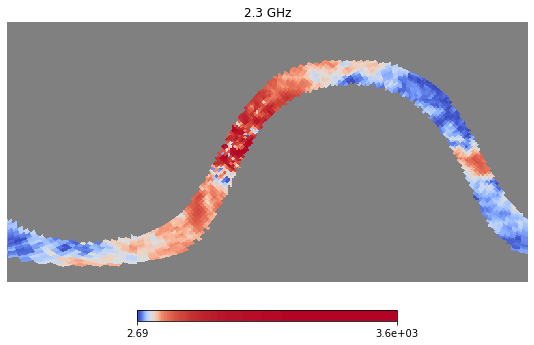

In [174]:
hp.cartview(S_to_N[0], norm = 'hist', title = '%s GHz' % fres[0], cmap = 'coolwarm') 

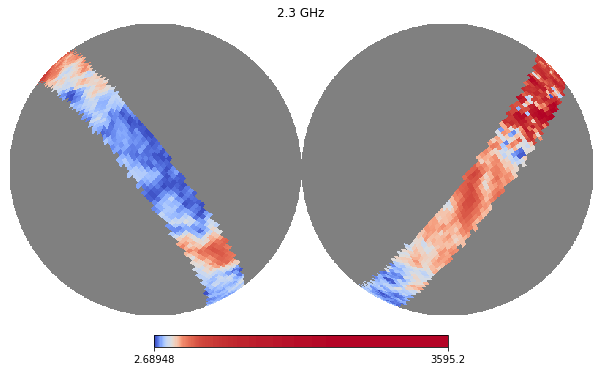

In [175]:
hp.orthview(S_to_N[0], rot = [-120, 30], norm = 'hist', title = '%s GHz' % fres[0], cmap = 'coolwarm') 

## geometrical mean of S/N

In [156]:
sn_both = gmean(total_P/total_sigma, axis = 0)
sn_C = gmean((total_P/total_sigma)[1:5], axis = 0)
sn_S = gmean([(total_P/total_sigma)[0],(total_P/total_sigma)[2],(total_P/total_sigma)[3],(total_P/total_sigma)[4]])

## pick out the overlapped region to a full sky map

In [252]:
Sn_both = sn_both*mask_both; Sn_C = sn_C*mask_both; Sn_S = sn_S*mask_both

In [257]:
np.argsort(Sn_both)[::-1]

array([5957, 6215, 6086, ..., 7763, 7762,    0])

## likelihood estimate

In [105]:
As_betas_both = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Emcee_As_betas_masked_both_32_with_SPASS_CBASS.npy')
As_betas_S = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Emcee_As_betas_masked_both_32_with_SPASS_only.npy')
As_betas_C = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Emcee_As_betas_masked_both_32_with_CBASS_only.npy')

Text(0.5, 1.0, 'Hisogram for beta_s of overlapped region')

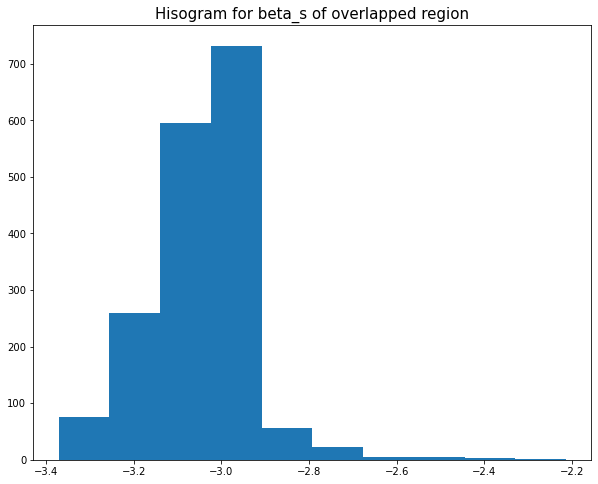

In [83]:
plt.figure(figsize = (10,8))
plt.hist(As_betas[1])
plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)

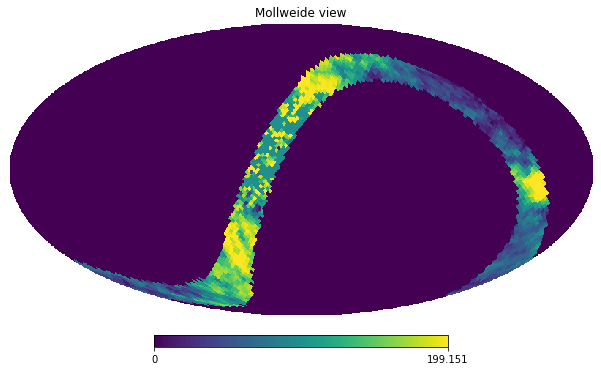

In [90]:
hp.mollview(As)
# hp.mollview(As_wide)

In [106]:
def Bp2f(m, mask_index):
    
    Betas = np.zeros(12*nside**2)
    Betas[mask_index] = m[1]
    Betas[Betas==0] = hp.UNSEEN
    
    As = np.zeros(12*nside**2)
    As[mask_index] = m[0]
    As[As==0] = hp.UNSEEN

    return As, Betas

In [110]:
betas_both = Bp2f(As_betas_both, mask_index)[1]
betas_C = Bp2f(As_betas_C, mask_index)[1]
betas_S = Bp2f(As_betas_S, mask_index)[1]

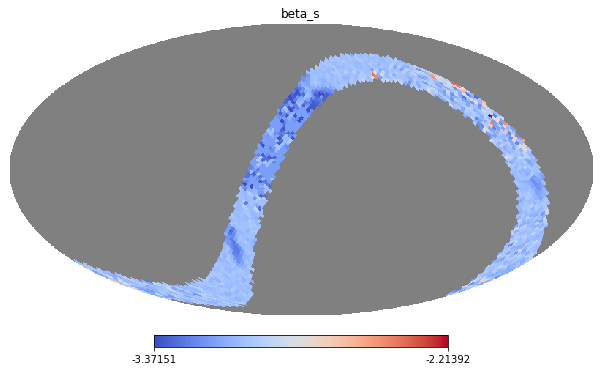

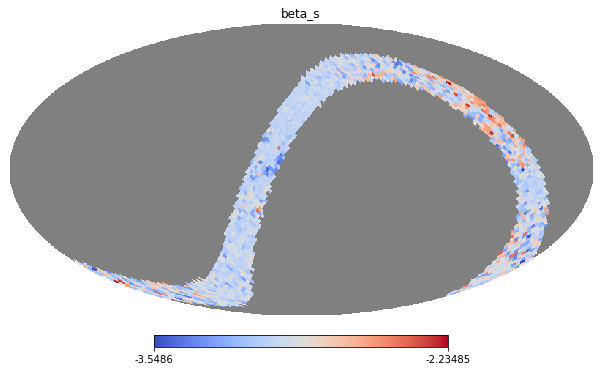

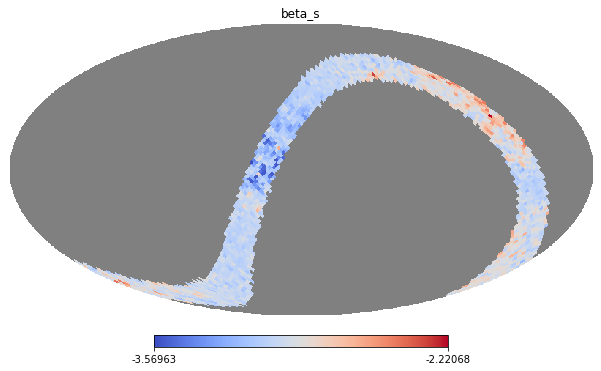

In [111]:
hp.mollview(betas_both, cmap = 'coolwarm', title = 'beta_s')
hp.mollview(betas_C, cmap = 'coolwarm', title = 'beta_s')
hp.mollview(betas_S, cmap = 'coolwarm', title = 'beta_s')

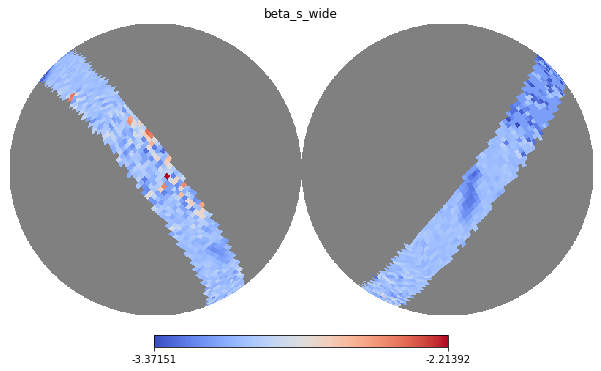

In [98]:
hp.orthview(Betas, rot = [-120, 30], cmap = 'coolwarm', title = 'beta_s_wide')

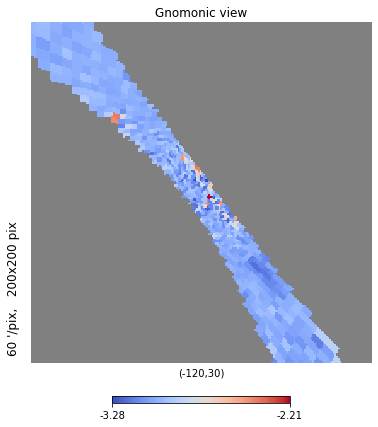

In [99]:
hp.gnomview(Betas, rot = [-120, 30], reso =60, cmap = 'coolwarm')

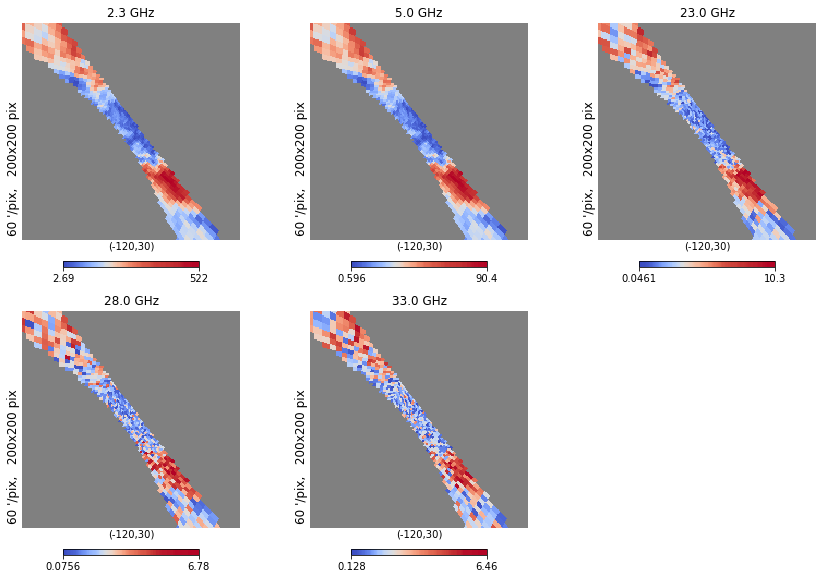

In [293]:
plt.figure(figsize = (12, 8))
plt.title('S/N', fontsize = 15)
plt.axis('off')
hp.gnomview(S_to_N[0], rot = [-120, 30], reso =60, norm = 'hist', sub = 231, title = '%s GHz' % fres[0], cmap = 'coolwarm') 
# hp.graticule()
hp.gnomview(S_to_N[1], rot = [-120, 30], reso =60, norm = 'hist', sub = 232, title = '%s GHz' % fres[1], cmap = 'coolwarm') 
hp.gnomview(S_to_N[2], rot = [-120, 30], reso =60, norm = 'hist', sub = 233, title = '%s GHz' % fres[2], cmap = 'coolwarm') 
hp.gnomview(S_to_N[3], rot = [-120, 30], reso =60, norm = 'hist', sub = 234, title = '%s GHz' % fres[3], cmap = 'coolwarm') 
hp.gnomview(S_to_N[4], rot = [-120, 30], reso =60, norm = 'hist', sub = 235, title = '%s GHz' % fres[4], cmap = 'coolwarm') 

## 2d of betas and S/N

Text(0.5, 0, '$log_{10}(S/N)$, Geometric mean')

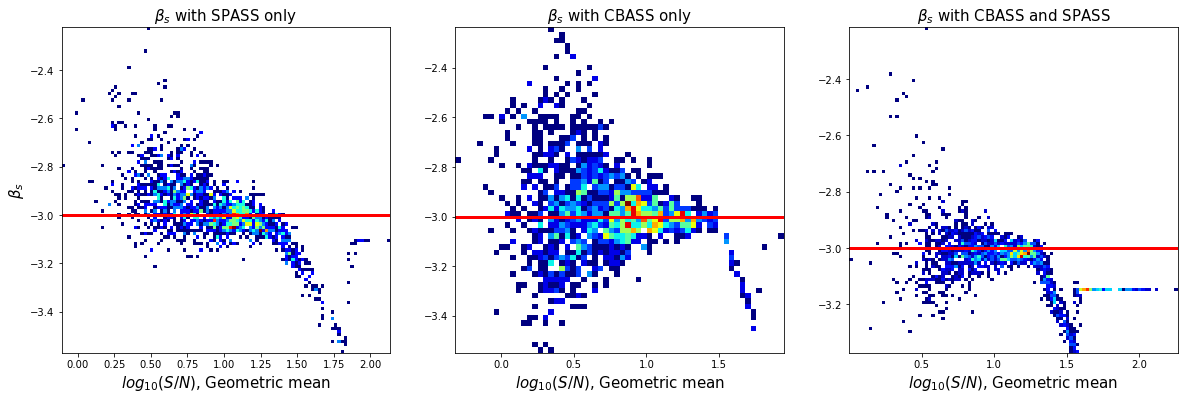

In [229]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
my_cmap = copy.copy(plt.cm.get_cmap("jet"))
my_cmap.set_under('w',0)

x0, y0 = sn_S[mask_index], betas_S[mask_index]
ax[0].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[0].set_title(r'$\beta_s$ with SPASS only', fontsize = 15)
ax[0].axhline(-3.0, c = 'red', lw = 3)
ax[0].set_ylabel(r'$\beta_s$', fontsize = 15)
ax[0].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)

x0, y0 = sn_C[mask_index], betas_C[mask_index]
ax[1].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[1].set_title(r'$\beta_s$ with CBASS only', fontsize = 15)
ax[1].axhline(-3.0, c = 'red', lw = 3)
ax[1].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)

x0, y0 = sn_both[mask_index], betas_both[mask_index]
ax[2].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[2].set_title(r'$\beta_s$ with CBASS and SPASS', fontsize = 15)
ax[2].axhline(-3.0, c = 'red', lw = 3)
ax[2].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)
# fig.colorbar(h)

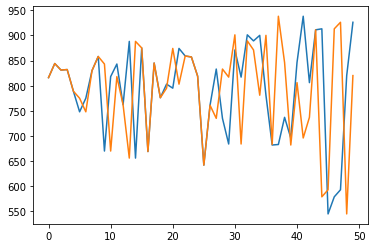

In [270]:
plt.plot(np.argsort(Sn_both[mask_index])[::-1][0:50])
plt.plot(np.argsort(P_nu0[mask_index])[::-1][0:50])

In [261]:
np.log10(sn_both[5957])

2.2665247539325257

In [259]:
betas_both[5957]

-3.140773427614687

In [265]:
np.argsort(P_nu0[mask_index])[::-1]

array([816, 844, 831, ..., 430, 261, 572])

# test

In [4]:
import Loglikeli

In [390]:
import importlib
importlib.reload(Loglikeli)

<module 'Loglikeli' from '/global/u2/j/jianyao/foreground/Loglikeli.py'>

In [6]:
mask_index

array([  744,   745,   746, ..., 12154, 12155, 12156])

In [12]:
npara = 2; 

def prior(cube):
    A0 = cube[0]*200 # 0-100
    beta = cube[1]*2 - 4
    
    return [A0, beta]

In [70]:
frelist = [1,2,3,4]
logL = Loglikeli.logLike(nside, fres,frelist, total_P, total_sigma, 3520)

In [73]:
n = 480
def ppp(n):
    for i in range(5):
        print(total_P[i][n],total_sigma[i][n], total_P[i][n]/total_sigma[i][n])
    return None

In [ ]:
P_nu0[480]

In [74]:
ppp(480)

46297.09774998118 73.39660293228953 630.7798440302691
4476.945002701883 40.906637057157766 109.44299812390751
40.99907174644842 3.903218746495618 10.503913413322824
23.31615480068719 3.886585863550039 5.9991353901004585
12.647126215678457 2.441095160848019 5.18092306212468


In [75]:
ppp(3520)

51775.70713739556 73.39660293228953 705.4237535374783
5002.060039899899 40.906637057157766 122.27991347493689
50.08143699111509 3.903218746495618 12.830804585594679
34.602936661227545 3.886585863550039 8.903170514190299
16.683521575556735 2.441095160848019 6.834441296324146


In [76]:
ppp(0)

5498.947668031113 73.39660293228953 74.92101062366673
572.3609940610992 40.906637057157766 13.991885797440505
7.7823924209247215 3.903218746495618 1.9938396811380088
1.1895021871665181 3.886585863550039 0.30605323770719867
4.104005904330205 2.441095160848019 1.6812150423929


In [29]:
# with Pool(cpu_count()-1) as executor:
        
#     sampler = dynesty.NestedSampler(logL.loglike, prior, npara, nlive=200, pool=executor, queue_size=cpu_count(), bootstrap = 0)
#     sampler.run_nested(dlogz = 0.1)
#     results = sampler.results

In [71]:
sampler = dynesty.NestedSampler(logL.loglike, prior, npara, nlive=400, bootstrap = 0)
sampler.run_nested(dlogz = 0.5)
results = sampler.results

3060it [00:12, 249.79it/s, +400 | bound: 13 | nc: 1 | ncall: 16908 | eff(%): 20.464 | loglstar:   -inf < -12.241 <    inf | logz: -19.019 +/-    nan | dlogz:  0.001 >  0.500]


In [35]:
sampler = dynesty.NestedSampler(logL.loglike, prior, npara, nlive=200, bootstrap = 0)
sampler.run_nested(dlogz = 0.5)
results = sampler.results

1444it [00:20, 71.85it/s, +200 | bound: 65 | nc: 1 | ncall: 26762 | eff(%):  6.143 | loglstar:   -inf < -11.675 <    inf | logz: -18.023 +/-    nan | dlogz:  0.002 >  0.500]


In [43]:
sampler = dynesty.NestedSampler(logL.loglike, prior, npara, nlive=200, bootstrap = 0)
sampler.run_nested(dlogz = 0.5)
results = sampler.results

2050it [01:27, 23.50it/s, +200 | bound: 217 | nc: 1 | ncall: 100783 | eff(%):  2.233 | loglstar:   -inf < -281.613 <    inf | logz: -291.046 +/-    nan | dlogz:  0.002 >  0.500]


In [ ]:
results.samples

Text(0.5, 0.98, 'Pixel 3520')

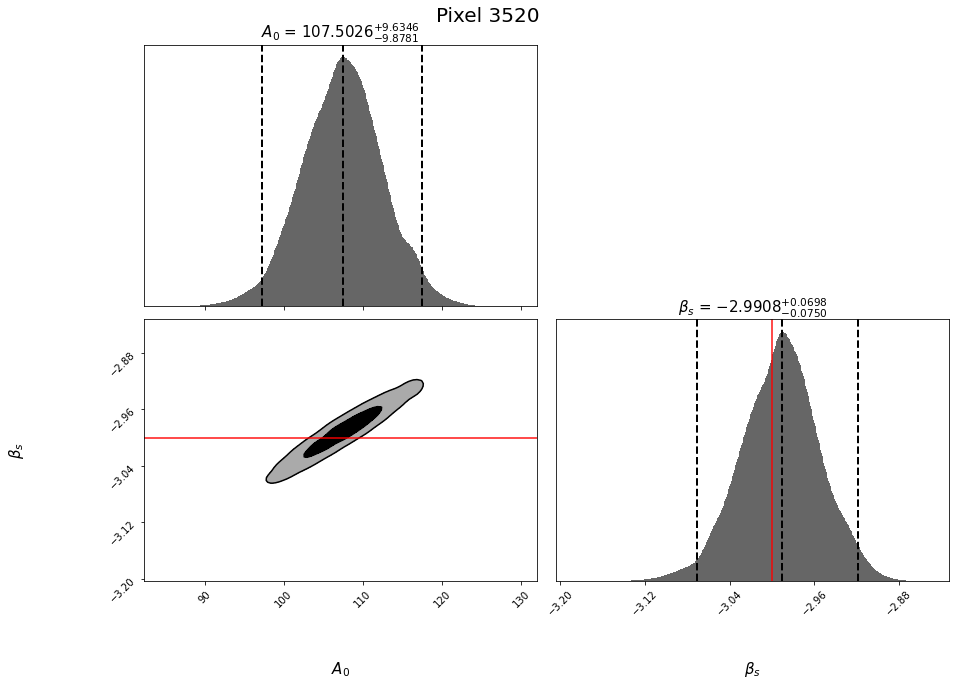

In [72]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

Text(0.5, 0.98, 'Pixel 745')

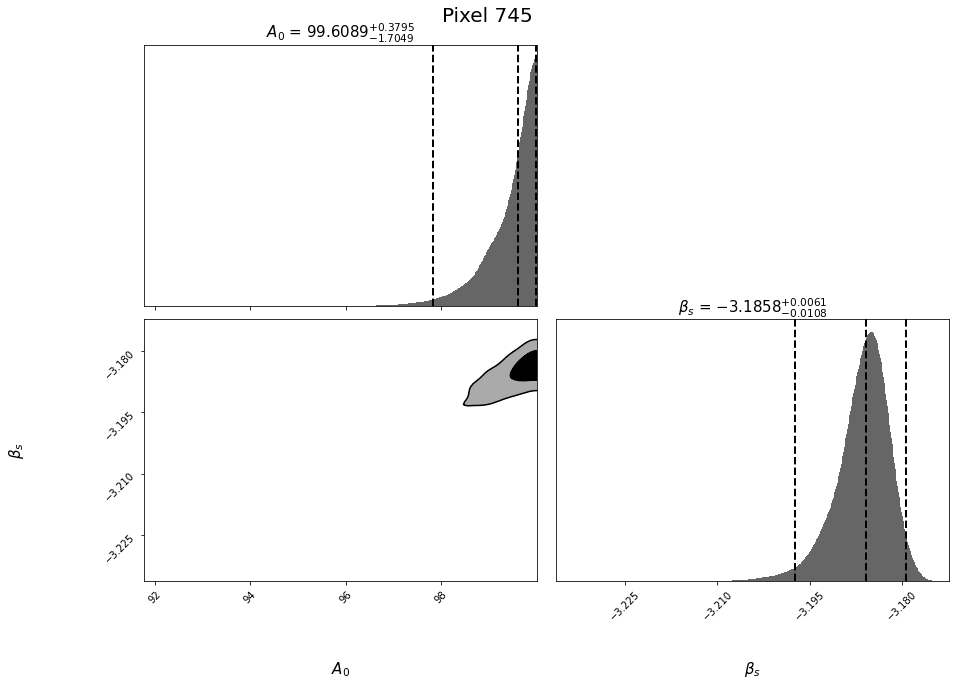

In [25]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

Text(0.5, 0.98, 'Pixel 744')

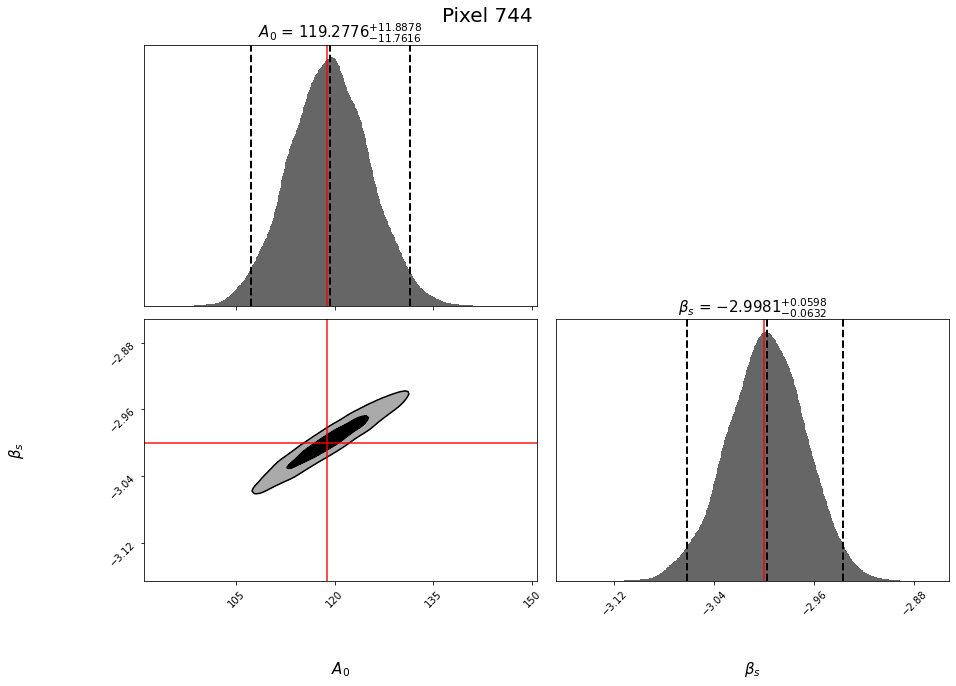

In [481]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];


labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

In [196]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])

In [209]:
dynesty.utils.quantile(samples[:,1], [0.5], weights)

[-3.0232436894048997]

In [206]:
dynesty.utils.quantile(samples[:,0], sig2, weights)

[42.51413064803956, 64.39738969437843, 88.79334606500959]

In [260]:
a = np.array([0,1,2,3,4])

In [263]:
frelist = [1,2,3]

In [264]:
a[frelist]

array([1, 2, 3])

In [508]:
from scipy import stats
stats.norm.ppf(0.95, loc =0, scale = 1)

1.6448536269514722